## Imports

In [1]:
import cv2
import mediapipe as mp
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import keras
import pickle
import time
import tensorflow as tf
from scipy.spatial import distance
from matplotlib import pyplot as plt
import random
import shutil

## Variables

In [2]:
mapping_numbers_variables = {0:'right_shoulder',
                             1:'right_elbow',
                             2:'right_wrist',
                             3:'left_shoulder',
                             4:'left_elbow',
                             5:'left_wrist'}

#Initialize the Mediapipe module with its corresponding parameters
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(model_complexity=0,min_detection_confidence=0.8,min_tracking_confidence=0.5)

In [3]:
model = keras.models.load_model('./models/model.h5')
scaler = pickle.load(open('./models/scaler.pkl','rb'))

#Select the number of keypoints to detect 
number_keypoints_to_detect = 6

#Select the indices of the landmarks of interest to detect from the output of the previous cell
indices_landmark_interest = [11, 12, 13, 14, 15 ,16] #0rder: left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist

### Functions

In [4]:
def mediapipe_inference(frame):
    results = pose.process(frame)
    frame_list1 = []
    start_index = 0
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            #If landmark visibility is not 0.5 save a NaN and this value will be replaced by the previous recorded value
            #Reference & first value is the callibraition picture 
            
            if landmark.visibility>0.5:
                if start_index in indices_landmark_interest:
                    image_hight, image_width, _ = frame.shape
                    frame = cv2.circle(frame, (int(landmark.x*image_width), int(landmark.y*image_hight)), radius=5, color = (0,255,0), thickness=-1)   
                    frame_list1.append(landmark.x*image_width)
                    frame_list1.append(landmark.y*image_hight) 
                    start_index = start_index+1
                else:
                    start_index = start_index+1
            else: 
                start_index = start_index+1
    return(frame_list1,frame)

def split_3_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 3
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/3)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+3
        output.append(frame_coordinates)
    return(output)

def split_2_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 2
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/2)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+2
        output.append(frame_coordinates)
    return(output)

### Load ground truth MOCAP test data

In [5]:
#Filtered_csv are files that just consider the recorded time of RGS movements in the MOCAP studio
adri_gt_df_2D = pd.read_csv('./data_export_1/Kinect/Adri/Adri01/filtered_csv/2d_TIMECODE_Adri01.csv')
adri_gt_df_3D = pd.read_csv('./data_export_1/Kinect/Adri/Adri01/filtered_csv/3d_TIMECODE_Adri01.csv')

#Empty dataframes with just column names
final_adri_gt_df_2D = pd.DataFrame(columns=list(adri_gt_df_2D))
final_adri_gt_df_3D = pd.DataFrame(columns=list(adri_gt_df_3D))

### IMPORTANT
Degut a que MediaPipe no detecta bé els keypoints en alguns frames del MOCAP (drawbacks: gent al darrera, bodysuit i mascareta) s'ha llançat una detecció de MediaPipe de tots els frames dels videos 01 tant de l'Adri com de'n Xavi. Posteriorment, manualment s'han seleccionat els frames on MediaPipe detectava correctament els keypoints --> Arxius dins de "frames_to_analyze".

L'objectiu de les següents cel·les és mantenir únicament la informació d'aquests arxius ja que els demés no serien útils per determinar correctament la presició de MediaPipe i la performance de Martinez et. al.

In [7]:
for filename in glob('./data_final_analysis/Adri/*.jpg'):
    frame_timecode = (round(float(filename.split('\\')[-1].split('.jpg')[0].split('_')[-1]),3))
    
    final_adri_gt_df_2D = final_adri_gt_df_2D.append(adri_gt_df_2D[adri_gt_df_2D['timecode']==adri_gt_df_2D[adri_gt_df_2D['timecode']<frame_timecode]['timecode'].max()])
    final_adri_gt_df_3D = final_adri_gt_df_3D.append(adri_gt_df_3D[adri_gt_df_2D['timecode']==adri_gt_df_3D[adri_gt_df_3D['timecode']<frame_timecode]['timecode'].max()])

In [8]:
final_adri_gt_df_2D = final_adri_gt_df_2D.drop(columns=['timecode'])
final_adri_gt_df_3D = final_adri_gt_df_3D.drop(columns=['timecode'])

In [9]:
final_adri_gt_df_2D.head(5)

,RightShoulder_2D,RightShoulder_2D.1,RightElbow_2D,RightElbow_2D.1,RightHand_2D,RightHand_2D.1,LeftShoulder_2D,LeftShoulder_2D.1,LeftElbow_2D,LeftElbow_2D.1,LeftHand_2D,LeftHand_2D.1
0,773.356,456.304,657.636,560.617,630.259,677.937,1067.365,425.891,1185.255,539.195,1199.198,669.846
1,775.469,455.505,657.920,563.827,629.928,677.783,1067.784,426.602,1182.842,544.381,1197.515,669.704
2,777.588,454.660,658.795,565.841,630.071,677.754,1068.364,428.452,1180.040,550.553,1196.000,669.003
3,779.998,454.083,659.575,567.215,630.194,677.750,1069.142,430.801,1177.158,558.169,1192.843,668.276
4,782.618,453.640,659.920,568.610,629.676,677.477,1070.220,433.442,1174.691,567.800,1186.762,667.777


In [10]:
final_adri_gt_df_3D.head(5)

,RightShoulder,RightShoulder.1,RightShoulder.2,RightElbow,RightElbow.1,RightElbow.2,RightHand,RightHand.1,RightHand.2,LeftShoulder,LeftShoulder.1,LeftShoulder.2,LeftElbow,LeftElbow.1,LeftElbow.2,LeftHand,LeftHand.1,LeftHand.2
0,-0.232,0.104,1.192,-0.434,-0.030,1.378,-0.394,-0.165,1.147,0.133,0.142,1.191,0.324,0.001,1.383,0.291,-0.158,1.166
1,-0.231,0.106,1.201,-0.434,-0.034,1.380,-0.394,-0.165,1.146,0.135,0.142,1.203,0.323,-0.006,1.391,0.289,-0.158,1.170
2,-0.230,0.107,1.209,-0.434,-0.037,1.383,-0.394,-0.165,1.148,0.137,0.141,1.214,0.321,-0.015,1.401,0.288,-0.158,1.173
3,-0.228,0.109,1.216,-0.434,-0.039,1.385,-0.395,-0.165,1.149,0.139,0.140,1.227,0.319,-0.027,1.409,0.285,-0.157,1.174
4,-0.226,0.110,1.221,-0.433,-0.041,1.386,-0.395,-0.164,1.148,0.142,0.137,1.238,0.316,-0.041,1.414,0.277,-0.156,1.172


In [11]:
final_adri_gt_df_3D = pd.DataFrame(split_3_coordinates(np.array(final_adri_gt_df_3D)))

In [12]:
df_2D = pd.DataFrame(columns=np.arange(0,number_keypoints_to_detect*2))
dfs_3D_list = []

n = 0
mp_time = []
nn_time = []

for filename in glob('./data_final_analysis/Adri/*.jpg'):
    
    frame = cv2.imread(filename)
    start1 = time.time()
    #MediaPipe inference
    detected_keypoints, frame = mediapipe_inference(frame)
    end1=time.time()
    mp_time.append(end1-start1)
    
    df_2D = df_2D.append(pd.DataFrame(detected_keypoints).T)
    
    #Changing prediction order to meet the ground-truth values
    df_2D= df_2D[[2,3,6,7,10,11,0,1,4,5,8,9]]


    #NEURAL NETWORK INFERENCE

    X = np.array([list(df_2D.iloc[n])]).astype(float)
    start2 = time.time()
    X_scaled = scaler.transform(X)
    z_predicted = model.predict(X_scaled)
    end2 = time.time()
    nn_time.append(end2-start2)
    df_pred_3d = pd.DataFrame(split_3_coordinates(z_predicted))
    dfs_3D_list.append(df_pred_3d)
    
    n = n+1
    
final_adri_predicted_df_3D = pd.concat(dfs_3D_list)

## Compute PCK@0.5

In [13]:
final_adri_predicted_df_2D = df_2D.reset_index().drop(columns=['index'])

df_adri_pred_2d = pd.DataFrame(split_2_coordinates(np.array(final_adri_predicted_df_2D).astype(float)))
df_adri_gt_2d = pd.DataFrame(split_2_coordinates(np.array(final_adri_gt_df_2D).astype(float)))

In [14]:
df_adri_pred_2d.head(5)

,0,1,2,3,4,5
0,"[801.3046073913574, 453.45826864242554]","[685.418586730957, 560.4616069793701]","[632.9990386962891, 729.1592073440552]","[1059.470443725586, 426.2100076675415]","[1162.2713470458984, 524.7948038578033]","[1218.4893035888672, 686.5910696983337]"
1,"[796.3543510437012, 453.4000754356384]","[684.7832107543945, 562.7106714248657]","[632.2465324401855, 726.1018109321594]","[1058.0363845825195, 421.1259877681732]","[1162.7356338500977, 524.7938704490662]","[1217.0884323120117, 669.6901273727417]"
2,"[794.9979972839355, 453.0927586555481]","[685.5447006225586, 563.0356907844543]","[632.2240447998047, 721.6659307479858]","[1055.8828353881836, 420.46552062034607]","[1162.7738571166992, 527.9458630084991]","[1216.3966369628906, 683.98357629776]"
3,"[795.0905799865723, 452.94013023376465]","[686.4023208618164, 565.8513021469116]","[631.4051628112793, 719.5617055892944]","[1055.7180404663086, 420.6210458278656]","[1162.4438095092773, 533.6895775794983]","[1214.8529434204102, 690.5496883392334]"
4,"[795.2768898010254, 452.93559193611145]","[686.436939239502, 568.4999942779541]","[629.9914741516113, 719.7929978370667]","[1055.7555770874023, 420.7543623447418]","[1160.0885009765625, 544.0024566650391]","[1214.6415710449219, 692.8685975074768]"


In [15]:
df_adri_gt_2d.head(5)

,0,1,2,3,4,5
0,"[773.356, 456.304]","[657.636, 560.617]","[630.259, 677.937]","[1067.365, 425.891]","[1185.255, 539.195]","[1199.198, 669.846]"
1,"[775.469, 455.505]","[657.92, 563.827]","[629.928, 677.783]","[1067.784, 426.602]","[1182.842, 544.381]","[1197.515, 669.704]"
2,"[777.588, 454.66]","[658.795, 565.841]","[630.071, 677.754]","[1068.364, 428.452]","[1180.04, 550.553]","[1196.0, 669.003]"
3,"[779.998, 454.083]","[659.575, 567.215]","[630.194, 677.75]","[1069.142, 430.801]","[1177.158, 558.169]","[1192.843, 668.276]"
4,"[782.618, 453.64]","[659.92, 568.61]","[629.676, 677.477]","[1070.22, 433.442]","[1174.691, 567.8]","[1186.762, 667.777]"


In [16]:
all_distances = []
for i in range(0,df_adri_pred_2d.shape[1]):
    keypoint_distances = []
    for j in range(0,len(df_adri_gt_2d[i])):
        keypoint_distances.append(distance.euclidean(df_adri_gt_2d[i][j], df_adri_pred_2d[i][j]))
    all_distances.append(keypoint_distances)

df_ED = pd.DataFrame(all_distances).T
df_ED = df_ED.rename(columns=mapping_numbers_variables)

In [17]:
#150 pixels is the head bone link of the woman virtual character. (Head-bone link --> Des de el entrecejo hasta inicio columna)
threshold = 0.5*150 

#Se calcula PCK por cada imágen y luego se hace la media

PCK_per_image = []
for i in range(0,len(df_ED)):
    condition = []
    for di in df_ED.iloc[i]:
        condition.append(di < threshold)
    PCK_per_image.append(sum(condition)/number_keypoints_to_detect)
        
        
PCK = sum(PCK_per_image)/len(PCK_per_image)
print('The PCK@0.5 for the MediaPipe Detections is: '+str(PCK))

The PCK@0.5 for the MediaPipe Detections is: 0.9308846761453394


## MediaPipe output vs GroundTruth (MOCAP)

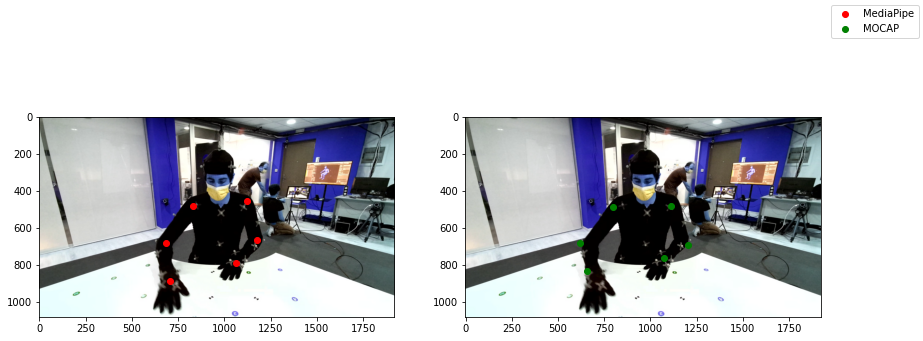

In [19]:
all_adri_images = glob('./data_final_analysis/Adri/*.jpg')

random_adri_image = random.sample(all_adri_images,1)
index = all_adri_images.index(random_adri_image[0])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
ax1.imshow(cv2.imread(random_adri_image[0]))
ax1.scatter(np.array(list(df_adri_pred_2d.iloc[index]))[:,0],np.array(list(df_adri_pred_2d.iloc[index]))[:,1],c='red',label='MediaPipe')

ax2.imshow(cv2.imread(random_adri_image[0]))
ax2.scatter(np.array(list(df_adri_gt_2d.iloc[index]))[:,0],np.array(list(df_adri_gt_2d.iloc[index]))[:,1],c='green',label='MOCAP')
fig.legend()

## Compute MPJPE

In [20]:
final_adri_gt_df_3D.head(5)

,0,1,2,3,4,5
0,"[-0.232, 0.104, 1.192]","[-0.434, -0.03, 1.378]","[-0.394, -0.165, 1.147]","[0.133, 0.142, 1.191]","[0.324, 0.001, 1.383]","[0.291, -0.158, 1.166]"
1,"[-0.231, 0.106, 1.201]","[-0.434, -0.034, 1.38]","[-0.394, -0.165, 1.146]","[0.135, 0.142, 1.203]","[0.323, -0.006, 1.391]","[0.289, -0.158, 1.17]"
2,"[-0.23, 0.107, 1.209]","[-0.434, -0.037, 1.383]","[-0.394, -0.165, 1.148]","[0.137, 0.141, 1.214]","[0.321, -0.015, 1.401]","[0.288, -0.158, 1.173]"
3,"[-0.228, 0.109, 1.216]","[-0.434, -0.039, 1.385]","[-0.395, -0.165, 1.149]","[0.139, 0.14, 1.227]","[0.319, -0.027, 1.409]","[0.285, -0.157, 1.174]"
4,"[-0.226, 0.11, 1.221]","[-0.433, -0.041, 1.386]","[-0.395, -0.164, 1.148]","[0.142, 0.137, 1.238]","[0.316, -0.041, 1.414]","[0.277, -0.156, 1.172]"


In [21]:
final_adri_predicted_df_3D = final_adri_predicted_df_3D.reset_index().drop(columns=['index'])
final_adri_predicted_df_3D.head(5)

,0,1,2,3,4,5
0,"[-0.13932607, 0.10492202, 1.1573851]","[-0.329619, -0.03255467, 1.3165329]","[-0.33873743, -0.21839583, 1.1194057]","[0.18174684, 0.13562283, 1.1586827]","[0.36203885, 0.0034154356, 1.3660045]","[0.37203172, -0.19908005, 1.1799923]"
1,"[-0.14956582, 0.105821334, 1.1692454]","[-0.33594012, -0.036093593, 1.3313692]","[-0.34599298, -0.21558711, 1.128583]","[0.1774283, 0.14314133, 1.1799518]","[0.3610315, -0.0023682863, 1.3968656]","[0.37019807, -0.19092396, 1.2032608]"
2,"[-0.14928624, 0.10588191, 1.168703]","[-0.3351586, -0.03731945, 1.3391231]","[-0.3461225, -0.21375796, 1.1358622]","[0.17685644, 0.14350602, 1.1730098]","[0.36116648, -0.0023914278, 1.3738925]","[0.3686533, -0.19757923, 1.181001]"
3,"[-0.14930272, 0.10621034, 1.1735586]","[-0.3353043, -0.04158087, 1.3452247]","[-0.3475117, -0.21269122, 1.1392967]","[0.17702925, 0.14415464, 1.1780261]","[0.36014915, -0.008511856, 1.3680643]","[0.3661351, -0.20065176, 1.1713678]"
4,"[-0.15004876, 0.106676094, 1.1805922]","[-0.33678475, -0.045261294, 1.3484708]","[-0.35067683, -0.21228686, 1.1391327]","[0.1771818, 0.1452863, 1.1915216]","[0.35720405, -0.022650465, 1.3722612]","[0.36426753, -0.20192891, 1.1671222]"


In [22]:
#Compute the euclidean distances of each 3D predicted keypoint vs the ground truth and generate a dataframe with the results.
all_distances = []
for keypoint in list(mapping_numbers_variables.keys()):
    
    keypoint_distances = []
    for i in range(0,len(final_adri_gt_df_3D[keypoint])):    
        keypoint_distances.append(distance.euclidean(final_adri_gt_df_3D[keypoint][i], final_adri_predicted_df_3D[keypoint][i]))
    all_distances.append(keypoint_distances)

df_PJPE = pd.DataFrame(all_distances).T

#Per joint position error dataframe euclidean distance in [mm]
(df_PJPE*1000).head(5)

,0,1,2,3,4,5
0,98.931788,121.161595,81.648694,58.833072,41.732920,91.921134
1,87.406609,109.476395,71.882424,48.297866,38.652165,93.719759
2,90.220910,108.142992,69.404027,57.227760,50.071310,90.196926
3,89.455670,106.440479,67.998125,62.144427,60.916307,92.169996
4,86.095475,103.363307,66.142212,58.878342,61.454124,98.736412


In [23]:
df_PJPE_mm = df_PJPE*1000
df_PJPE_mm = df_PJPE_mm.rename(columns=mapping_numbers_variables)

In [24]:
means = []
for column in list(df_PJPE.columns):
    means.append(df_PJPE[column].mean())
    
mpjpe = sum(means)/len(df_PJPE.columns)
print('The obtained MPJPE error is: '+'\033[1m'+str(mpjpe*1000)+'mm')

The obtained MPJPE error is: 67.1704256100922mm


In [25]:
df_PJPE.mean()*1000

0    76.766948
1    96.095641
2    58.902036
3    43.718346
4    75.704087
5    51.835496
dtype: float64

In [26]:
df_PJPE.std()*1000

0    15.161968
1    24.520026
2    25.938860
3    14.505734
4    20.340522
5    24.424938
dtype: float64

([<matplotlib.axis.XTick at 0x1c7d024cee0>,
 [Text(1, 0, 'right_shoulder'),
  Text(2, 0, 'right_elbow'),
  Text(3, 0, 'right_wrist'),
  Text(4, 0, 'left_shoulder'),
  Text(5, 0, 'left_elbow'),
  Text(6, 0, 'left_wrist')])

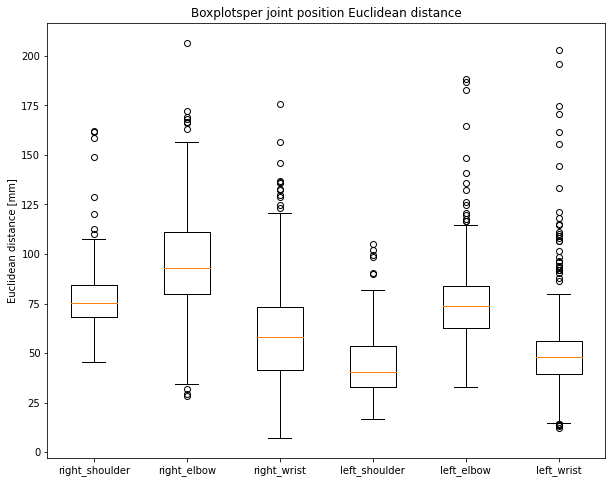

In [27]:
fig = plt.figure(figsize=(10,8))
plt.boxplot(df_PJPE*1000)
plt.title('Boxplotsper joint position Euclidean distance')
plt.ylabel('Euclidean distance [mm]')
#plt.ylim([0,80])
positions = list(mapping_numbers_variables.keys())
positions = [i+1 for i in positions]
labels = list(mapping_numbers_variables.values())
plt.xticks(positions,labels)

## Outliers analysis

In [28]:
q3_list = list(df_PJPE_mm.quantile(0.75)) #Defining third quartile per keypoint
q1_list = list(df_PJPE_mm.quantile(0.25)) #Defining first quartile per keypoint
iqr_list = list(np.array(q3_list)-np.array(q1_list)) #Defining IQR per keypoint

#Defining the threshold to be an outlier per each keypoint
maximum_values_list = np.array(q3_list) + 1.5*np.array(iqr_list) #Defining threshold to be outliers (Maximum)
max_values_dict = dict(zip(mapping_numbers_variables.values(),maximum_values_list))
max_values_dict 

{'right_shoulder': 108.24783031272202,
 'right_elbow': 158.17125385776993,
 'right_wrist': 121.35463028342944,
 'left_shoulder': 84.66196538520043,
 'left_elbow': 116.22594677228909,
 'left_wrist': 81.26980120035913}

##### NOTE: He realizado el outlier analysis a partir de los valores que superan el Maximum threshold. No obstante, podría hacerlo para los valores que superan el Q3 threshold
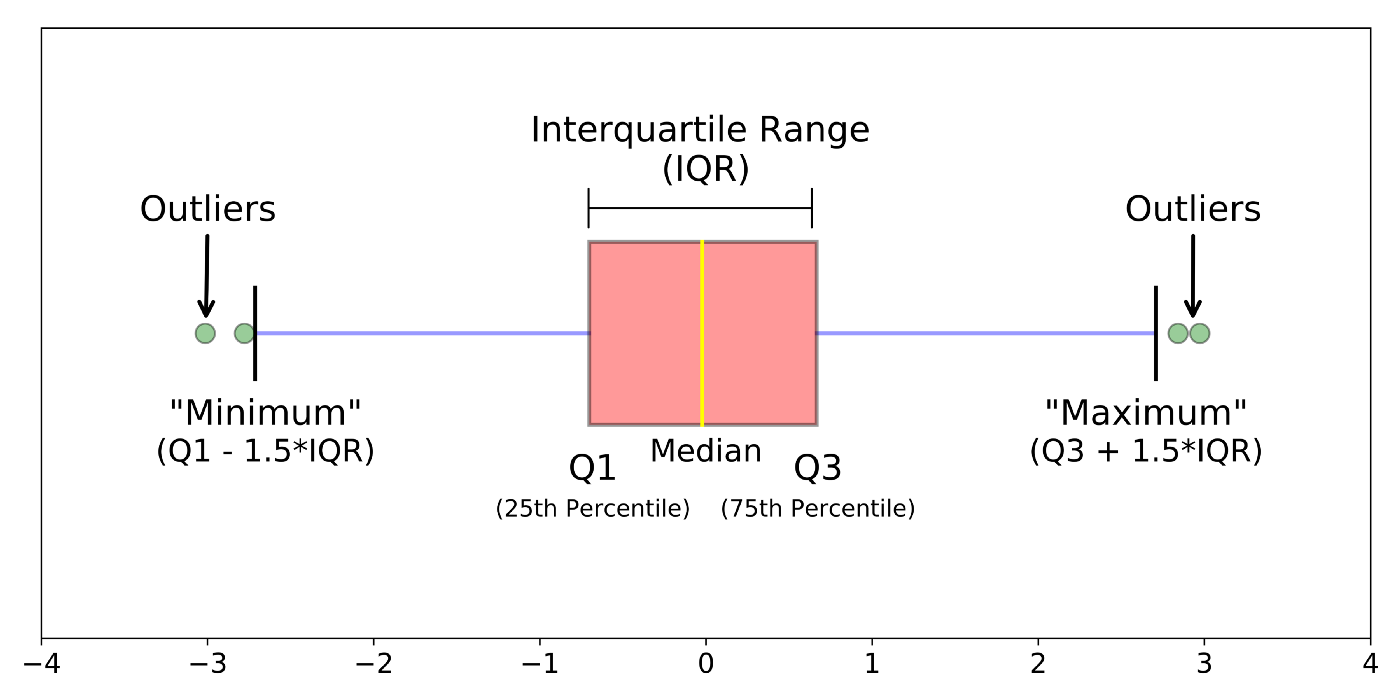

In [272]:
maximum_values_list

array([108.24783031, 158.17125386, 121.35463028,  84.66196539,
       116.22594677,  81.2698012 ])

In [29]:
def how_many_outliers(keypoint):
    df = pd.DataFrame(columns=[keypoint])
    for key in max_values_dict.keys():
        if key == keypoint:
            outliers = df_PJPE_mm[df_PJPE_mm[keypoint] > max_values_dict.get(keypoint)]
            df = df.append(outliers)
    return(df)

In [30]:
#Euclidean distance outliers
df_outliers_ed_right_shoulder = how_many_outliers('right_shoulder')
df_outliers_ed_right_elbow =  how_many_outliers('right_elbow')
df_outliers_ed_right_wrist =  how_many_outliers('right_wrist')

df_outliers_ed_left_shoulder =  how_many_outliers('left_shoulder')
df_outliers_ed_left_elbow = how_many_outliers('left_elbow')
df_outliers_ed_left_wrist =  how_many_outliers('left_wrist')

In [31]:
#Listado de dataframes outliers
outliers = {
    'right_shoulder': df_outliers_ed_right_shoulder, 
    'right_elbow': df_outliers_ed_right_elbow, 
    'right_wrist': df_outliers_ed_right_wrist,
    'left_shoulder': df_outliers_ed_left_shoulder, 
    'left_elbow': df_outliers_ed_left_elbow,
    'left_wrist': df_outliers_ed_left_wrist
}

for element in outliers.keys():
    print('There are '+str(len(outliers[element])) +' outliers for keypoint: '+str(element))

There are 8 outliers for keypoint: right_shoulder
There are 7 outliers for keypoint: right_elbow
There are 12 outliers for keypoint: right_wrist
There are 6 outliers for keypoint: left_shoulder
There are 15 outliers for keypoint: left_elbow
There are 33 outliers for keypoint: left_wrist


##  Objective: Obtain the 3D coordinates of each outlier per keypoint and plot them to detect patterns and regions where outliers are generated

In [33]:
#I want to obtain the original ground-truth coordinates to know exactly which movement is not detected properly by RGSpipe
final_adri_gt_df_3D = final_adri_gt_df_3D.rename(columns=mapping_numbers_variables)

#Obtain the 3D coordinates of the outlier keypoints and the other keypoints in the same frame where the outlier is detected to ease the plotting
#GROUND-TRUTH 3D COORDINATES OF FRAMES WITH OUTLIERS
outliers_3D_coordinates_right_shoulder = final_adri_gt_df_3D.iloc[list(df_outliers_ed_right_shoulder.index)]
outliers_3D_coordinates_right_elbow = final_adri_gt_df_3D.iloc[list(df_outliers_ed_right_elbow.index)]
outliers_3D_coordinates_right_wrist = final_adri_gt_df_3D.iloc[list(df_outliers_ed_right_wrist.index)]

outliers_3D_coordinates_left_shoulder = final_adri_gt_df_3D.iloc[list(df_outliers_ed_left_shoulder.index)]
outliers_3D_coordinates_left_elbow = final_adri_gt_df_3D.iloc[list(df_outliers_ed_left_elbow.index)]
outliers_3D_coordinates_left_wrist = final_adri_gt_df_3D.iloc[list(df_outliers_ed_left_wrist.index)]

outliers_3D_dict = {
    'right_shoulder':outliers_3D_coordinates_right_shoulder,
    'right_elbow': outliers_3D_coordinates_right_elbow,
    'right_wrist': outliers_3D_coordinates_right_wrist,
    'left_shoulder': outliers_3D_coordinates_left_shoulder,
    'left_elbow': outliers_3D_coordinates_left_elbow,
    'left_wrist': outliers_3D_coordinates_left_wrist}

In [34]:
def extract_outlier_coordinates_per_keypoint(outliers_3D_coordinates_df, objective_keypoint):
    x_coords = []
    y_coords = []
    z_coords = []

    x_coords_objective_keypoint = []
    y_coords_objective_keypoint = []
    z_coords_objective_keypoint = []

    for i in range(0,len(outliers_3D_coordinates_df)):
        x_coord_frame = []
        y_coord_frame = []
        z_coord_frame = []

        x_coord_frame_objective_keypoint = []
        y_coord_frame_objective_keypoint = []
        z_coord_frame_objective_keypoint = []
        
        for keypoint in list(mapping_numbers_variables.values()):
            if keypoint == objective_keypoint:
                x_coord_frame_objective_keypoint.append(outliers_3D_coordinates_df.iloc[i][keypoint][0])
                y_coord_frame_objective_keypoint.append(outliers_3D_coordinates_df.iloc[i][keypoint][1])
                z_coord_frame_objective_keypoint.append(outliers_3D_coordinates_df.iloc[i][keypoint][2])
            else:
                x_coord_frame.append(outliers_3D_coordinates_df.iloc[i][keypoint][0])
                y_coord_frame.append(outliers_3D_coordinates_df.iloc[i][keypoint][1])
                z_coord_frame.append(outliers_3D_coordinates_df.iloc[i][keypoint][2])

        x_coords.append(x_coord_frame)
        y_coords.append(y_coord_frame)
        z_coords.append(z_coord_frame)

        x_coords_objective_keypoint.append(x_coord_frame_objective_keypoint)
        y_coords_objective_keypoint.append(y_coord_frame_objective_keypoint)
        z_coords_objective_keypoint.append(z_coord_frame_objective_keypoint)
    
    return(x_coords, y_coords, z_coords, x_coords_objective_keypoint, y_coords_objective_keypoint, z_coords_objective_keypoint)

In [45]:
from mpl_toolkits.mplot3d import Axes3D

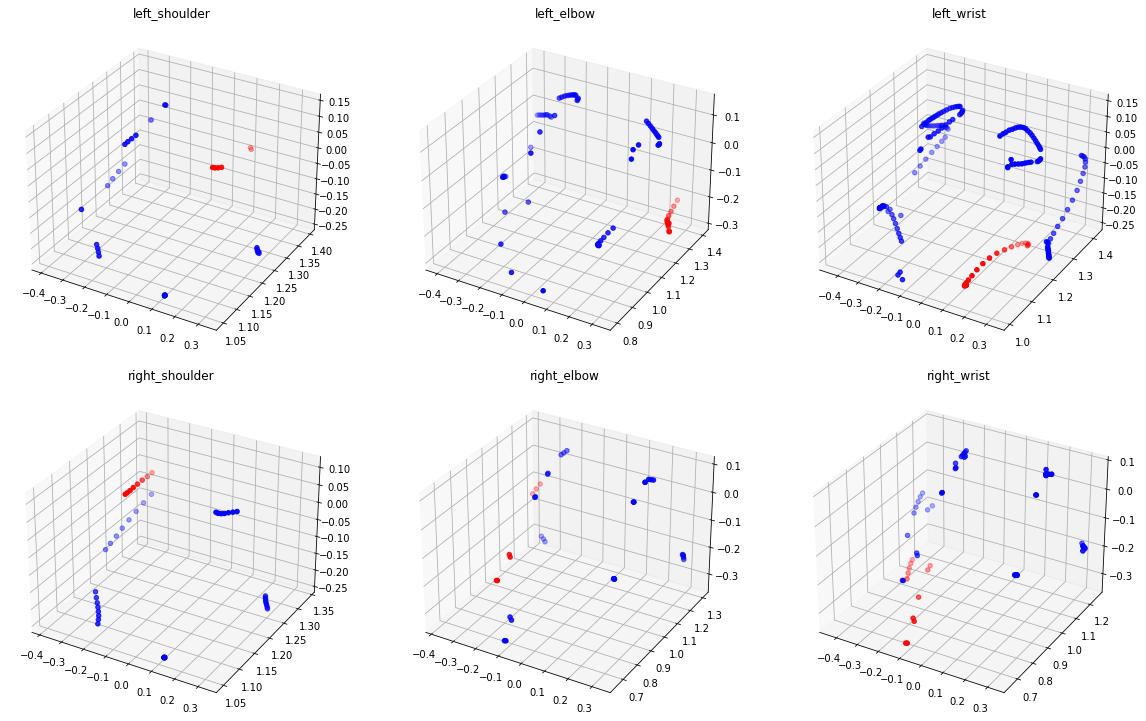

In [50]:
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=1)
j = 0

for i in range(0,len(outliers_3D_dict)):
    if i <= 2: 
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        x_coords_0, y_coords_0, z_coords_0, x_coords_objective_keypoint, y_coords_objective_keypoint, z_coords_objective_keypoint= extract_outlier_coordinates_per_keypoint(outliers_3D_dict[mapping_numbers_variables[i]], mapping_numbers_variables[i])
        ax.scatter(x_coords_0, z_coords_0,y_coords_0,c='blue',label='Other_Keypoints')
        ax.scatter(x_coords_objective_keypoint, z_coords_objective_keypoint,y_coords_objective_keypoint,c='red',label=mapping_numbers_variables[i])
        ax.set_title(mapping_numbers_variables[i])
    else: 
        ax = fig.add_subplot(2, 3, j+1, projection='3d')
        x_coords_0, y_coords_0, z_coords_0, x_coords_objective_keypoint, y_coords_objective_keypoint, z_coords_objective_keypoint = extract_outlier_coordinates_per_keypoint(outliers_3D_dict[mapping_numbers_variables[i]], mapping_numbers_variables[i])
        ax.scatter(x_coords_0, z_coords_0,y_coords_0,c='blue',label='Other_Keypoints')
        ax.scatter(x_coords_objective_keypoint, z_coords_objective_keypoint,y_coords_objective_keypoint,c='red',label=mapping_numbers_variables[i])
        ax.set_title(mapping_numbers_variables[i])
        j = j+1

### Save the frames in folders containing outliers for each specific keypoint 

In [36]:
path_frames_analyze = './data_final_analysis/Adri/'
destination_outliers = './data_final_analysis/Adri/outliers/'

In [37]:
for keypoint in list(outliers_3D_dict.keys()):
    for i in range(0,len(glob(path_frames_analyze+'*.jpg'))):
        if i in list(outliers_3D_dict[keypoint].index):
            shutil.copy(glob(path_frames_analyze+'*.jpg')[i], destination_outliers+keypoint+'/'+glob(path_frames_analyze+'*.jpg')[i].split('\\')[-1])

### Obtain insights about the detected outliers

1. Run MediaPipe Again on those frames to see if the 2D detection is performed correctly
2. Plot the 2D ground truth keypoints for those frames and the 3D too and see the differences


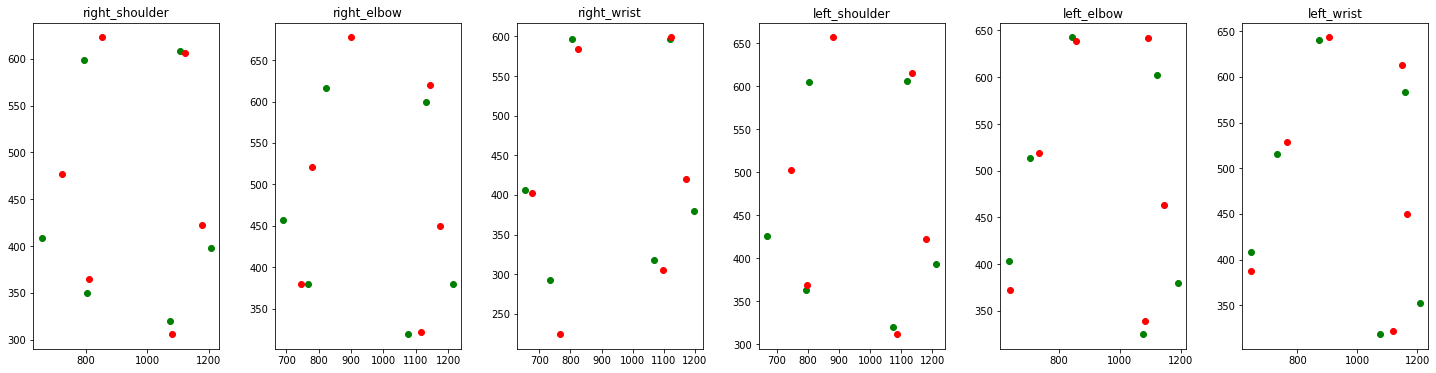

In [269]:
#Mediapipe - Predicted 2D coordinates of frames containing outliers per each keypoint
outliers_2D_mp_coordinates_right_shoulder = df_adri_pred_2d.iloc[list(df_outliers_ed_right_shoulder.index)]
outliers_2D_mp_coordinates_right_elbow = df_adri_pred_2d.iloc[list(df_outliers_ed_right_elbow.index)]
outliers_2D_mp_coordinates_right_wrist = df_adri_pred_2d.iloc[list(df_outliers_ed_right_wrist.index)]

outliers_2D_mp_coordinates_left_shoulder = df_adri_pred_2d.iloc[list(df_outliers_ed_left_shoulder.index)]
outliers_2D_mp_coordinates_left_elbow = df_adri_pred_2d.iloc[list(df_outliers_ed_left_elbow.index)]
outliers_2D_mp_coordinates_left_wrist = df_adri_pred_2d.iloc[list(df_outliers_ed_left_wrist.index)]

#Groundtruth - Blender 2D coordinates of frames containing outliers per each keypoint
outliers_2D_gt_coordinates_right_shoulder = df_adri_gt_2d.iloc[list(df_outliers_ed_right_shoulder.index)]
outliers_2D_gt_coordinates_right_elbow = df_adri_gt_2d.iloc[list(df_outliers_ed_right_elbow.index)]
outliers_2D_gt_coordinates_right_wrist = df_adri_gt_2d.iloc[list(df_outliers_ed_right_wrist.index)]

outliers_2D_gt_coordinates_left_shoulder = df_adri_gt_2d.iloc[list(df_outliers_ed_left_shoulder.index)]
outliers_2D_gt_coordinates_left_elbow = df_adri_gt_2d.iloc[list(df_outliers_ed_left_elbow.index)]
outliers_2D_gt_coordinates_left_wrist = df_adri_gt_2d.iloc[list(df_outliers_ed_left_wrist.index)]

#For each outlier keypoint I want to plot the 2D prediction versus the ground truth 
outliers_2D_mp_list = [
    outliers_2D_mp_coordinates_right_shoulder,
    outliers_2D_mp_coordinates_right_elbow,
    outliers_2D_mp_coordinates_right_wrist, 
    outliers_2D_mp_coordinates_left_shoulder, 
    outliers_2D_mp_coordinates_left_elbow,
    outliers_2D_mp_coordinates_left_wrist
]

outliers_2D_gt_list = [
    outliers_2D_gt_coordinates_right_shoulder, 
    outliers_2D_gt_coordinates_right_elbow, 
    outliers_2D_gt_coordinates_right_wrist,
    outliers_2D_gt_coordinates_left_shoulder,
    outliers_2D_gt_coordinates_left_elbow,
    outliers_2D_gt_coordinates_left_wrist,
]

#For each keypoint I want to select a random pair of 2D predicted and ground-truth entries that have been detected as outlier and plot them
j = 0

fig = plt.figure(figsize=(25,6))
plt.subplots_adjust(wspace = 0.3)


for i in range(0,len(outliers_2D_mp_list)):
    index = random.randint(0,len(outliers_2D_mp_list[i])-1) #-1 Because starts on 0 not on 1. 

    x_gt = np.array(list(outliers_2D_gt_list[i].iloc[index]))[:,0]
    y_gt = 1080-np.array(list(outliers_2D_gt_list[i].iloc[index]))[:,1]

    x_pred = np.array(list(outliers_2D_mp_list[i].iloc[index]))[:,0]
    y_pred = 1080-np.array(list(outliers_2D_mp_list[i].iloc[index]))[:,1]
    
    ax = fig.add_subplot(1, 6, i+1)
    ax.scatter(x_gt,y_gt,c='Green',label='Ground_truth')
    ax.scatter(x_pred,y_pred,c='red',label='Predicted')
    ax.set_title(mapping_numbers_variables[i])

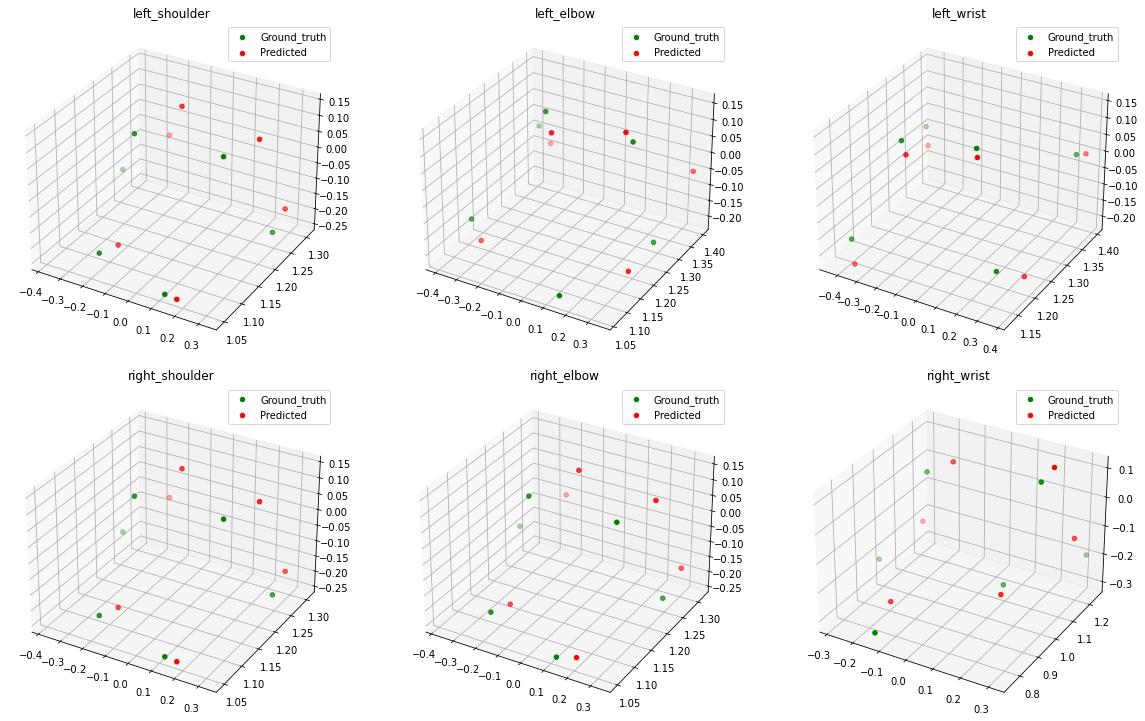

In [270]:
#MediaPipe 
outliers_3D_mp_coordinates_right_shoulder = final_adri_predicted_df_3D.iloc[list(df_outliers_ed_right_shoulder.index)]
outliers_3D_mp_coordinates_right_elbow = final_adri_predicted_df_3D.iloc[list(df_outliers_ed_right_elbow.index)]
outliers_3D_mp_coordinates_right_wrist = final_adri_predicted_df_3D.iloc[list(df_outliers_ed_right_wrist.index)]

outliers_3D_mp_coordinates_left_shoulder = final_adri_predicted_df_3D.iloc[list(df_outliers_ed_left_shoulder.index)]
outliers_3D_mp_coordinates_left_elbow = final_adri_predicted_df_3D.iloc[list(df_outliers_ed_left_elbow.index)]
outliers_3D_mp_coordinates_left_wrist = final_adri_predicted_df_3D.iloc[list(df_outliers_ed_left_wrist.index)]


#Ground truth
outliers_3D_gt_coordinates_right_shoulder = final_adri_gt_df_3D.iloc[list(df_outliers_ed_right_shoulder.index)]
outliers_3D_gt_coordinates_right_elbow = final_adri_gt_df_3D.iloc[list(df_outliers_ed_right_elbow.index)]
outliers_3D_gt_coordinates_right_wrist = final_adri_gt_df_3D.iloc[list(df_outliers_ed_right_wrist.index)]

outliers_3D_gt_coordinates_left_shoulder = final_adri_gt_df_3D.iloc[list(df_outliers_ed_left_shoulder.index)]
outliers_3D_gt_coordinates_left_elbow = final_adri_gt_df_3D.iloc[list(df_outliers_ed_left_elbow.index)]
outliers_3D_gt_coordinates_left_wrist = final_adri_gt_df_3D.iloc[list(df_outliers_ed_left_wrist.index)]

#For each outlier keypoint I want to plot the 2D prediction versus the ground truth 
outliers_3D_mp_list = [
    outliers_3D_mp_coordinates_right_shoulder,
    outliers_3D_mp_coordinates_right_elbow,
    outliers_3D_mp_coordinates_right_wrist, 
    outliers_3D_mp_coordinates_left_shoulder, 
    outliers_3D_mp_coordinates_left_elbow,
    outliers_3D_mp_coordinates_left_wrist
]

outliers_3D_gt_list = [
    outliers_3D_gt_coordinates_right_shoulder, 
    outliers_3D_gt_coordinates_right_elbow, 
    outliers_3D_gt_coordinates_right_wrist,
    outliers_3D_gt_coordinates_left_shoulder,
    outliers_3D_gt_coordinates_left_elbow,
    outliers_3D_gt_coordinates_left_wrist,
]

#For each keypoint I want to select a random pair of 3D predicted and ground-truth entries that have been detected as outlier and plot them
j = 0

fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace = 1)


for i in range(0,len(outliers_3D_mp_list)):
    index = random.randint(0,len(outliers_3D_mp_list[i])-1) #-1 Because starts on 0 not on 1. 

    x_gt = np.array(list(outliers_3D_gt_list[i].iloc[index]))[:,0]
    y_gt = np.array(list(outliers_3D_gt_list[i].iloc[index]))[:,1]
    z_gt = np.array(list(outliers_3D_gt_list[i].iloc[index]))[:,2]

    x_pred = np.array(list(outliers_3D_mp_list[i].iloc[index]))[:,0]
    y_pred = np.array(list(outliers_3D_mp_list[i].iloc[index]))[:,1]
    z_pred = np.array(list(outliers_3D_mp_list[i].iloc[index]))[:,2]
    
    if i <=2:
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        ax.scatter(x_gt,z_gt,y_gt,c='Green',label='Ground_truth')
        ax.scatter(x_pred,z_pred,y_pred,c='red',label='Predicted')
        ax.set_title(mapping_numbers_variables[i])
        ax.legend()
    else:
        ax = fig.add_subplot(2, 3, j+1, projection='3d')
        ax.scatter(x_gt,z_gt,y_gt,c='Green',label='Ground_truth')
        ax.scatter(x_pred,z_pred,y_pred,c='red',label='Predicted')
        ax.set_title(mapping_numbers_variables[i])
        ax.legend()
        j = j+1

## Plotting 3D random sample GT vs Prediction

It can be an outlier or not, just a random image from Frames to analyze

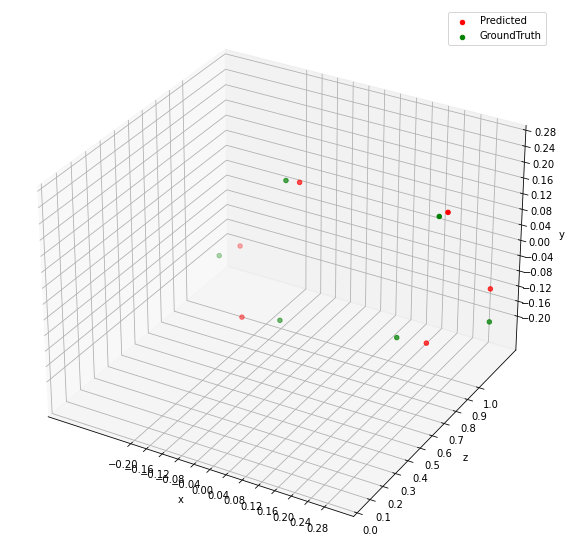

In [37]:
index = random.randint(0,len(glob('.//*.jpg')))

x_line = []
y_line = []
z_line = []

for keypoint in list(final_adri_predicted_df_3D.iloc[index]):
    x_line.append(keypoint[0])
    y_line.append(keypoint[1])
    z_line.append(keypoint[2])
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

x_line2 = []
y_line2 = []
z_line2 = []

for keypoint in list(final_adri_gt_df_3D.iloc[index]):
    x_line2.append(keypoint[0])
    y_line2.append(keypoint[1])
    z_line2.append(keypoint[2])
    



ax.scatter(x_line, z_line,y_line,c='red',label='Predicted')
ax.scatter(x_line2, z_line2,y_line2,c='green',label='GroundTruth')

ax.set_xticks(np.arange(-0.2,0.3,0.04))
ax.set_xlabel('x')
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_ylabel('z')
ax.set_zticks(np.arange(-0.2,0.3,0.04))
ax.set_zlabel('y')
#ax.set_title('Predicted 3D coordinates')
ax.legend()